In [1]:
import sys
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imutils

In [2]:
def debug_plot_cv_img(img, cmap=None):
    fig, ax = plt.subplots(figsize=(10, 22))
    ax.imshow(img, interpolation='nearest', cmap=cmap)
    plt.tight_layout()

In [3]:
def to_binary(img, blockSize=11, constant=2):
    if len(img.shape) > 2:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    binary = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, blockSize, constant)
    return binary

In [4]:
def denoise(img, strength=3, output=None, templateWindowSize=7, searchWindowSize=21):
    return cv.fastNlMeansDenoising(img, output, strength, templateWindowSize, searchWindowSize)

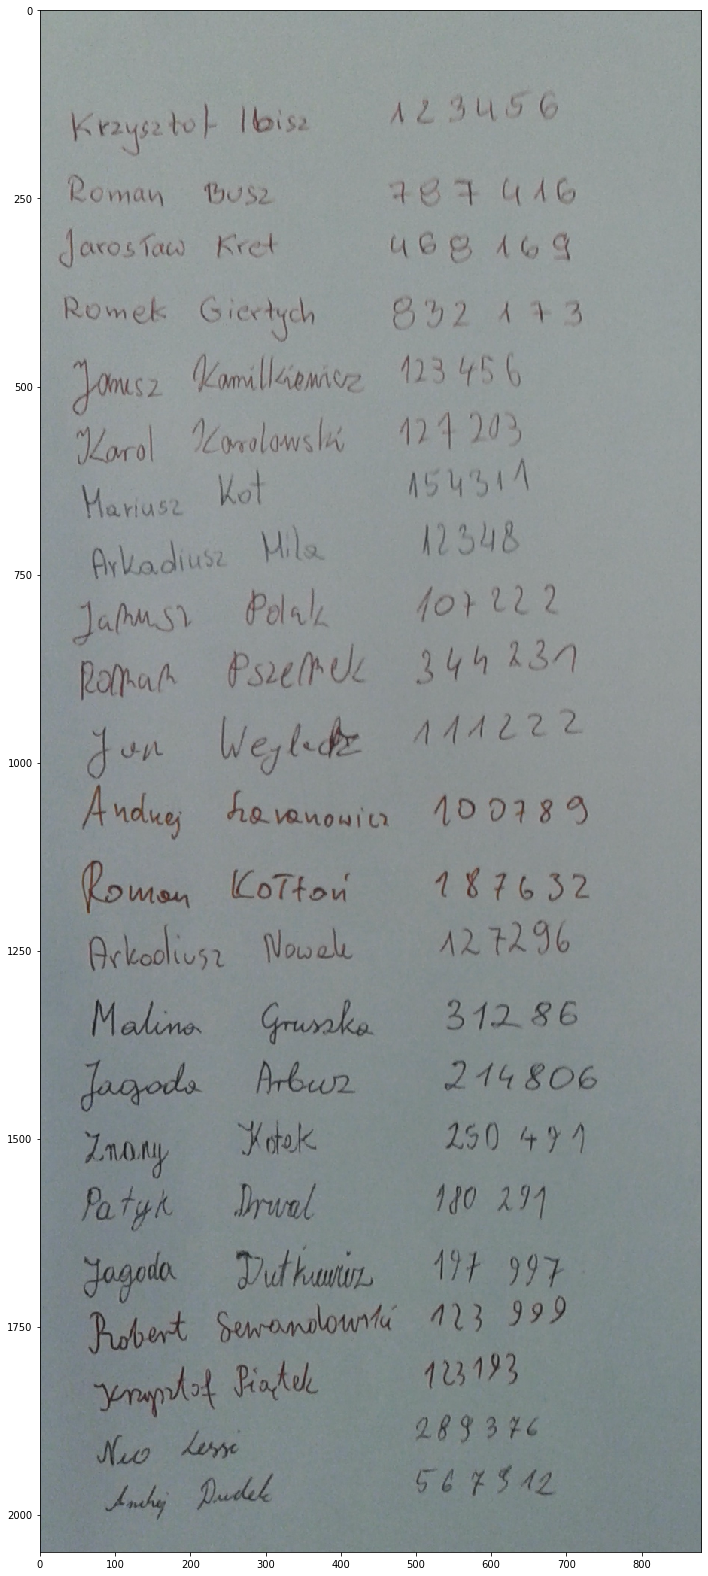

In [7]:
img = cv.imread("data/20.png")
img = img[250:2300, 120:1000]
debug_plot_cv_img(img)

In [8]:
def erode(img, kernel_size=2):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv.erode(img, kernel)

def dilate(img, kernel_size=2):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv.dilate(img, kernel)

In [13]:
def split_rows(binary_image, plot=True, threshold=2, show_rows=False, offset=0):
    aera = get_text_aera(binary_image)
    rotated = rotate_text(aera, binary_image)
    upper, lower = find_boundries(rotated, threshold)
    
    if plot:
        drawing = draw_boundries(rotated, upper, lower)
        debug_plot_cv_img(drawing)
        
    return split(rotated, upper, lower, show_rows, offset)
        
def get_text_aera(binary_image): 
    pts = cv.findNonZero(binary_image)
    return cv.minAreaRect(pts)

def rotate_text(text_aera, binary_image):
    (cx,cy), (w,h), ang = text_aera
        
    M = cv.getRotationMatrix2D((cx,cy), ang, scale=1.0)
    rotated = cv.warpAffine(binary_image, M, (img.shape[1], img.shape[0]))
    return rotated

def find_boundries(img, threshold=2):
    hist = cv.reduce(img, 1, cv.REDUCE_AVG).reshape(-1)
    h,w = img.shape[:2]
    uppers = [y for y in range(h-1) if hist[y]<=threshold and hist[y+1]>threshold]
    lowers = [y for y in range(h-1) if hist[y]>threshold and hist[y+1]<=threshold]
    return uppers, lowers
    
def draw_boundries(img, upper, lower):
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    h, w = img.shape[:2]
    for y in upper:
        cv.line(img, (0,y), (w, y), (255,0,0), 1)

    for y in lower:
        cv.line(img, (0,y), (w, y), (0,255,0), 1)
        
    return img

def split(img, upper, lower, show=False, offset=0):
    assert len(upper) == len(lower)
    
    rows = []
    for i in range(len(upper)):
        upper_boundry = max(0, upper[i] - offset)
        lower_boundry = min(img.shape[0], lower[i] + offset)
#         image = img[upper[i]:lower[i], :]
        image = img[upper_boundry:lower_boundry, :]
        rows.append(image)
        
    if show:
        for row in rows:
            debug_plot_cv_img(row)
    
    return rows

plt.rcParams.update({'figure.max_open_warning': 0})
img = cv.imread("data/20.png")
img = img[250:2300, 120:1000]
img = cv.GaussianBlur(img,(3,3),0)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

## (2) threshold
th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
threshed = dilate(threshed, 20)
split_rows(threshed, threshold=4, show_rows=True, offset=15)

error: OpenCV(4.3.0) /io/opencv/modules/imgproc/src/convhull.cpp:143: error: (-215:Assertion failed) total >= 0 && (depth == CV_32F || depth == CV_32S) in function 'convexHull'


In [11]:
img.shape[0]

2050